<a href="https://colab.research.google.com/github/alxmzr/Colab/blob/main/1_NN_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 7.3 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=016e69eeff4cb5ef787bab8b162a65472f3ea01b7daa8bf2ad82f1c0d4bcea31
  Stored in directory: /root/.cache/pip/wheels/73/2b/cb/099980278a0c9a3e57ff1a89875ec07bfa0b6fcbebb9a8cad3
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=421c77119b5c32ab656d8146887faad0ea056fd39d1e36f0e27c2ca0f79e96ce
  Stored in directory: /root/.cache/pip/wheels/d6/9c/58/ee

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:
init_df

,open,high,low,close,adjclose,volume,ticker
2020-03-16,54.480499,57.273499,53.354000,53.650002,53.650002,96520000,GOOGL
2020-03-17,54.532001,56.299999,52.455002,55.903000,55.903000,83194000,GOOGL
2020-03-18,52.997002,55.249500,51.849998,54.559502,54.559502,93044000,GOOGL
2020-03-19,54.410999,57.630501,52.777500,55.583500,55.583500,74064000,GOOGL
2020-03-20,56.544998,56.924000,53.105000,53.410500,53.410500,82878000,GOOGL
...,...,...,...,...,...,...,...
2023-03-20,100.120003,101.750000,99.870003,101.220001,101.220001,32960400,GOOGL
2023-03-21,101.250000,105.099998,101.220001,104.919998,104.919998,42110300,GOOGL
2023-03-22,104.269997,106.589996,103.330002,103.370003,103.370003,43427400,GOOGL
2023-03-23,105.059998,106.300003,104.459999,105.599998,105.599998,40797800,GOOGL


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
init_df

,close,date
2020-03-16,53.650002,2020-03-16
2020-03-17,55.903000,2020-03-17
2020-03-18,54.559502,2020-03-18
2020-03-19,55.583500,2020-03-19
2020-03-20,53.410500,2020-03-20
...,...,...
2023-03-20,101.220001,2023-03-20
2023-03-21,104.919998,2023-03-21
2023-03-22,103.370003,2023-03-22
2023-03-23,105.599998,2023-03-23


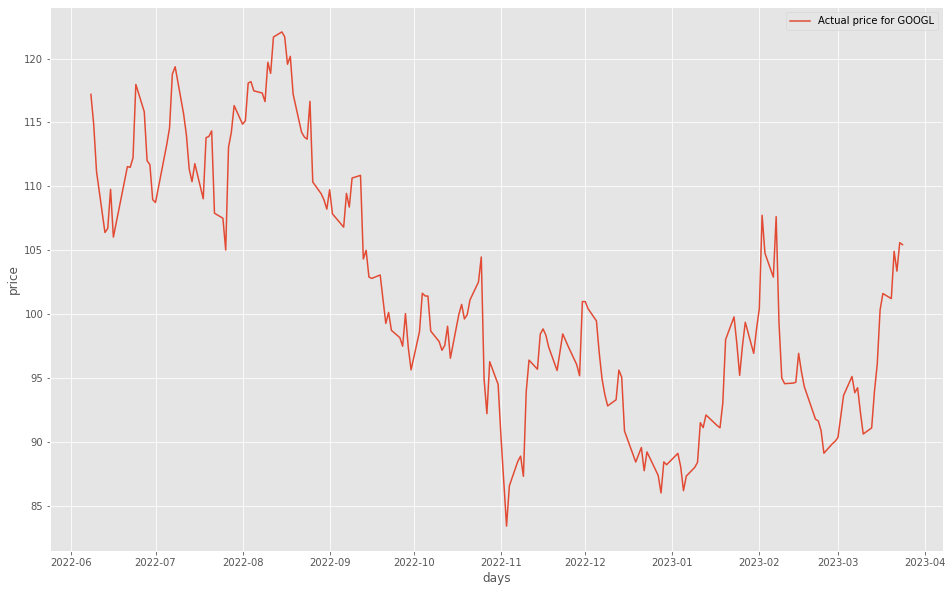

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
init_df

,close,date,scaled_close
2020-03-16,53.650002,2020-03-16,0.009714
2020-03-17,55.903000,2020-03-17,0.032909
2020-03-18,54.559502,2020-03-18,0.019077
2020-03-19,55.583500,2020-03-19,0.029619
2020-03-20,53.410500,2020-03-20,0.007248
...,...,...,...
2023-03-20,101.220001,2023-03-20,0.499460
2023-03-21,104.919998,2023-03-21,0.537552
2023-03-22,103.370003,2023-03-22,0.521594
2023-03-23,105.599998,2023-03-23,0.544553


In [11]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [12]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-03-16   53.650002 2020-03-16      0.009714  0.029619
 2020-03-17   55.903000 2020-03-17      0.032909  0.007248
 2020-03-18   54.559502 2020-03-18      0.019077  0.000000
 2020-03-19   55.583500 2020-03-19      0.029619  0.039060
 2020-03-20   53.410500 2020-03-20      0.007248  0.024446
 ...                ...        ...           ...       ...
 2023-03-15   96.110001 2023-03-15      0.446851  0.499460
 2023-03-16  100.320000 2023-03-16      0.490194  0.537552
 2023-03-17  101.620003 2023-03-17      0.503578  0.521594
 2023-03-20  101.220001 2023-03-20      0.499460  0.544553
 2023-03-21  104.919998 2023-03-21      0.537552  0.542906
 
 [760 rows x 4 columns], array([[0.39537433],
        [0.4248188 ],
        [0.4468507 ],
        [0.49019375],
        [0.50357765],
        [0.4994595 ],
        [0.53755194],
        [0.52159435],
        [0.54455274],
        [0.54290557]], dtype=float32), array([[[0.009713590980266695

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [ ]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 8s 28ms/step - loss: 0.0199
Epoch 2/80
95/95 [==============================] - 3s 31ms/step - loss: 0.0047
Epoch 3/80
95/95 [==============================] - 3s 26ms/step - loss: 0.0049
Epoch 4/80
95/95 [==============================] - 2s 24ms/step - loss: 0.0033
Epoch 5/80
95/95 [==============================] - 2s 24ms/step - loss: 0.0037
Epoch 6/80
95/95 [==============================] - 3s 29ms/step - loss: 0.0035
Epoch 7/80
95/95 [==============================] - 3s 34ms/step - loss: 0.0028
Epoch 8/80
95/95 [==============================] - 3s 28ms/step - loss: 0.0025
Epoch 9/80
95/95 [==============================] - 3s 29ms/step - loss: 0.0025
Epoch 10/80
95/95 [==============================] - 3s 27ms/step - loss: 0.0033
Epoch 11/80
95/95 [==============================] - 3s 31ms/step - loss: 0.0025
Epoch 12/80
95/95 [==============================] - 2s 22ms/step - loss: 0.0022
Epoch 13/80
95/95 [==================

In [ ]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

In [ ]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

In [ ]:
copy_df

In [ ]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

In [ ]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()